## Projet Machine Learning : Prédiction du score IMDb des films
*Projet de Machine Learning : préparation des données, entraînement de modèles, validation et test externe.*


*  **Source du jeu de données** : [imdb_top_1000.csv](https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows?resource=download)
*   **Producteur du jeu de données** : Kaggle
*   **Date de l'export** : 25/06/2025


In [ ]:
import pandas as pd, numpy as np, os
from pathlib import Path

df = pd.read_csv("imdb_top_1000.csv")

## 1. Nettoyage et prétraitement

In [ ]:
target_col = "IMDB_Rating" if "IMDB_Rating" in df.columns else None
if target_col is None:
    candidates = [c for c in df.columns if "rating" in c.lower()]
    if not candidates:
        raise ValueError("Colonne cible non trouvée (IMDB_Rating / rating).")
    target_col = candidates[0]

y = df[target_col]
X = df.drop(columns=[target_col])
print("Cible:", target_col, "| X shape:", X.shape, "| y shape:", y.shape)

Cible: IMDB_Rating | X shape: (1000, 15) | y shape: (1000,)


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
print("Num cols:", len(num_cols), "| Cat cols:", len(cat_cols))

Num cols: 2 | Cat cols: 13


In [ ]:
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols)
    ],
    remainder="drop"
)

## 2. Séparation Train/Test & Modélisation

In [ ]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
print("Train:", X_train.shape, "| Test:", X_test.shape)

Train: (800, 15) | Test: (200, 15)


**Modèle 1 : Linear Regression**

In [ ]:
model_lin = Pipeline(steps=[("prep", preprocessor), ("reg", LinearRegression())])
model_lin.fit(X_train, y_train)
y_pred_lin = model_lin.predict(X_test)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
round(rmse_lin, 4)
print("Régression linéaire - TEST")
print("R²:", round(r2_score(y_test, y_pred_lin), 4))
print(rmse_lin)

Régression linéaire - TEST
R²: 0.2965
0.21235885849935007


**Modèle 2 : Random Forest**

In [ ]:
model_rf = Pipeline(steps=[("prep", preprocessor), ("rf", RandomForestRegressor(n_estimators=300, random_state=RANDOM_STATE))])
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
round(rmse_rf, 4)
print("\nRandom Forest - TEST")
print("R²:", round(r2_score(y_test, y_pred_rf), 4))
print(rmse_rf)


Random Forest - TEST
R²: 0.3681
0.20126005150882192


## 3. Evaluation des modèles



In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_lin = cross_val_score(model_lin, X, y, cv=cv, scoring="r2")
cv_rf  = cross_val_score(model_rf,  X, y, cv=cv, scoring="r2")
print("CV R² - Lin:", np.round(cv_lin, 4), "| Moyenne:", round(cv_lin.mean(), 4))
print("CV R² - RF :", np.round(cv_rf, 4),  "| Moyenne:", round(cv_rf.mean(), 4))

CV R² - Lin: [0.2965 0.5262 0.4361 0.3532 0.4541] | Moyenne: 0.4132
CV R² - RF : [0.3701 0.4581 0.3827 0.3241 0.3901] | Moyenne: 0.385


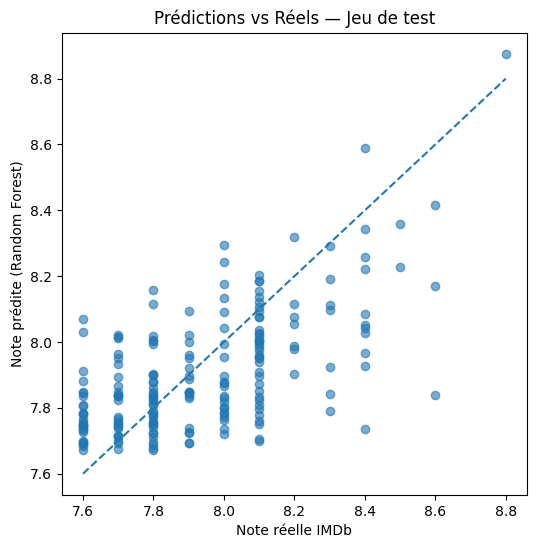

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.xlabel("Note réelle IMDb")
plt.ylabel("Note prédite (Random Forest)")
plt.title("Prédictions vs Réels — Jeu de test")
lo, hi = float(np.nanmin(y_test)), float(np.nanmax(y_test))
plt.plot([lo, hi], [lo, hi], "--")
plt.show()

**Test manuel : 1 film**

In [ ]:
sample = X_test.iloc[[0]]
true_rating = y_test.iloc[0]
pred = model_rf.predict(sample)[0]
print("Test manuel — Note réelle:", true_rating, "| Note prédite:", round(pred, 2))

Test manuel — Note réelle: 7.9 | Note prédite: 7.85


## Validation externe avec un autre dataset

*  **Source du jeu de données** : [all_movies_dataset.csv](https://www.kaggle.com/datasets/sonalgire/movie-metadata-collection-4900-films)
*   **Producteur du jeu de données** : Kaggle
*   **Date de l'export** : 25/06/2025

In [ ]:
df_ext = pd.read_csv("all_movies_dataset.csv")
print(df_ext.shape)
print(df_ext.columns)

rename_map = {
    "Runtime (min)": "Runtime",
    "Genres": "Genre",
    "Year": "Released_Year",
    "Rating": "IMDB_Rating"
}
df_ext_ren = df_ext.rename(columns=rename_map)

y_ext = df_ext_ren["IMDB_Rating"] if "IMDB_Rating" in df_ext_ren.columns else None
X_ext_raw = df_ext_ren.drop(columns=["IMDB_Rating"]) if "IMDB_Rating" in df_ext_ren.columns else df_ext_ren.copy()

missing = [c for c in X.columns if c not in X_ext_raw.columns]
extra   = [c for c in X_ext_raw.columns if c not in X.columns]

X_ext = X_ext_raw.copy()
for c in missing:
    X_ext[c] = np.nan
X_ext = X_ext[X.columns]

print(f"Colonnes manquantes ajoutées: {len(missing)} | Colonnes ignorées: {len(extra)}")
print("X_ext shape:", X_ext.shape)

(4900, 9)
Index(['Title', 'Year', 'Rating', 'Runtime (min)', 'Genres', 'Language',
       'IMDb Code', 'Summary', 'URL'],
      dtype='object')
Colonnes manquantes ajoutées: 12 | Colonnes ignorées: 5
X_ext shape: (4900, 15)


In [ ]:
y_pred_ext = model_rf.predict(X_ext)
rmse_ext = np.sqrt(mean_squared_error(y_test, y_pred_rf))

if y_ext is not None:
    print("Validation externe (RF)")
    print("R² externe:", round(r2_score(y_ext, y_pred_ext), 4))
    print(rmse_ext)
else:
    print("Aucune colonne 'IMDB_Rating'/'Rating' trouvée pour comparer — on affiche quelques prédictions.")
    print(pd.DataFrame({"Title": df_ext.get("Title", pd.Series(range(len(y_pred_ext))))[:10],
                        "Pred": np.round(y_pred_ext[:10], 2)}))


Validation externe (RF)
R² externe: -2.572
0.20126005150882192


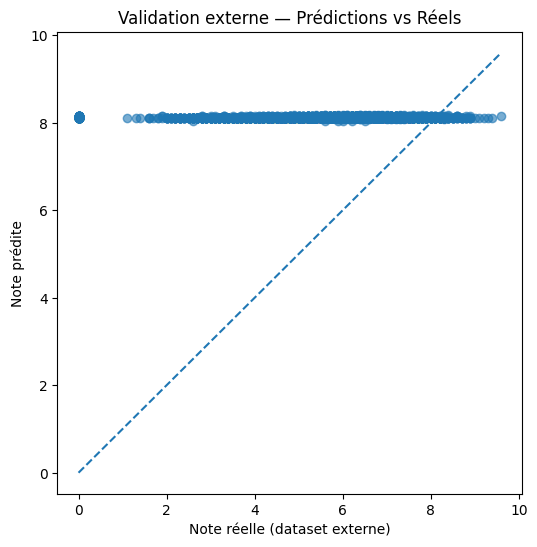

In [ ]:
if y_ext is not None:
    plt.figure(figsize=(6,6))
    plt.scatter(y_ext, y_pred_ext, alpha=0.6)
    plt.xlabel("Note réelle (dataset externe)")
    plt.ylabel("Note prédite")
    plt.title("Validation externe — Prédictions vs Réels")
    lo, hi = float(np.nanmin(y_ext)), float(np.nanmax(y_ext))
    plt.plot([lo, hi], [lo, hi], "--")
    plt.show()